# Walmart Sales Forecasting: A Time Series Analysis

## Project Goal

The objective of this project is to develop and evaluate various time series forecasting models to accurately predict weekly sales for Walmart stores. The project explores classical statistical methods, modern automated forecasting libraries, and advanced machine learning techniques.

## Key Challenges

The primary challenge in sales forecasting is effectively modeling complex time-based patterns, including:
- **Trend:** The long-term increase or decrease in sales.
- **Seasonality:** The repeating patterns within a year (e.g., holiday spikes, summer lulls).
- **External Factors:** The impact of holidays and promotional events.

## Methodology

1.  **Exploratory Data Analysis (EDA):** Load, merge, and visualize the data to identify underlying patterns.
2.  **Time Series Decomposition & Stationarity:** Deconstruct the time series and test for stationarity as a prerequisite for classical models.
3.  **Modeling & Evaluation:** Build and compare three distinct models:
    - **SARIMA:** A classical statistical model for benchmark performance.
    - **Prophet:** A modern forecasting library from Meta, designed for seasonal data with holidays.
    - **XGBoost:** A supervised machine learning model using engineered features (lags, rolling averages) to capture complex relationships.

### 1. Library Imports and Setup

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from prophet import Prophet

import warnings
warnings.filterwarnings("ignore") #Ignore convergence warnings

### 2. Data Loading

In [5]:
# Load the three separate datasets.
train_df = pd.read_csv("train.csv")
features_df = pd.read_csv("features.csv")
stores_df = pd.read_csv("stores.csv")

print("Train Data:")
print(train_df.head())
print("\n ---------- \n")

print("Features Data:")
print(features_df.head())
print("\n ---------- \n")

print("Stores Data:")
print(stores_df.head())

Train Data:
   Store  Dept        Date  Weekly_Sales  IsHoliday
0      1     1  2010-02-05      24924.50      False
1      1     1  2010-02-12      46039.49       True
2      1     1  2010-02-19      41595.55      False
3      1     1  2010-02-26      19403.54      False
4      1     1  2010-03-05      21827.90      False

 ---------- 

Features Data:
   Store        Date  Temperature  Fuel_Price  MarkDown1  MarkDown2  \
0      1  2010-02-05        42.31       2.572        NaN        NaN   
1      1  2010-02-12        38.51       2.548        NaN        NaN   
2      1  2010-02-19        39.93       2.514        NaN        NaN   
3      1  2010-02-26        46.63       2.561        NaN        NaN   
4      1  2010-03-05        46.50       2.625        NaN        NaN   

   MarkDown3  MarkDown4  MarkDown5         CPI  Unemployment  IsHoliday  
0        NaN        NaN        NaN  211.096358         8.106      False  
1        NaN        NaN        NaN  211.242170         8.106       True

### 3. Data Merging and Preparation

In [7]:
# Merge the train and stores dataframes on the store column.
df = pd.merge(train_df, stores_df, on='Store', how='left')

# Merge the combined dataframe with the features dataframe on 'Store' and 'Date'.
df = pd.merge(df, features_df, on=['Store', 'Date'], how='left')

# Clean up the duplicate IsHoliday column created by the merge.
df.drop('IsHoliday_y', axis=1, inplace=True)
df.rename(columns={'IsHoliday_x': 'IsHoliday'}, inplace=True)

# Convert the 'Date' column to a proper datetime format.
df['Date'] = pd.to_datetime(df['Date'])

# Set 'Date' column as the index, which is essential for time series analysis.
df.set_index('Date', inplace=True)

# Display the first few rows and info of the new merged dataframe.
print("--- Head of Merged Dataframe ---")
print(df.head())
print("\n--- Info of Merged Datafram ---")
df.info()

--- Head of Merged Dataframe ---
            Store  Dept  Weekly_Sales  IsHoliday Type    Size  Temperature  \
Date                                                                         
2010-02-05      1     1      24924.50      False    A  151315        42.31   
2010-02-12      1     1      46039.49       True    A  151315        38.51   
2010-02-19      1     1      41595.55      False    A  151315        39.93   
2010-02-26      1     1      19403.54      False    A  151315        46.63   
2010-03-05      1     1      21827.90      False    A  151315        46.50   

            Fuel_Price  MarkDown1  MarkDown2  MarkDown3  MarkDown4  MarkDown5  \
Date                                                                            
2010-02-05       2.572        NaN        NaN        NaN        NaN        NaN   
2010-02-12       2.548        NaN        NaN        NaN        NaN        NaN   
2010-02-19       2.514        NaN        NaN        NaN        NaN        NaN   
2010-02-26     

### 4. Exploratory Data Analysis (EDA)

Plotting total weekly sales...


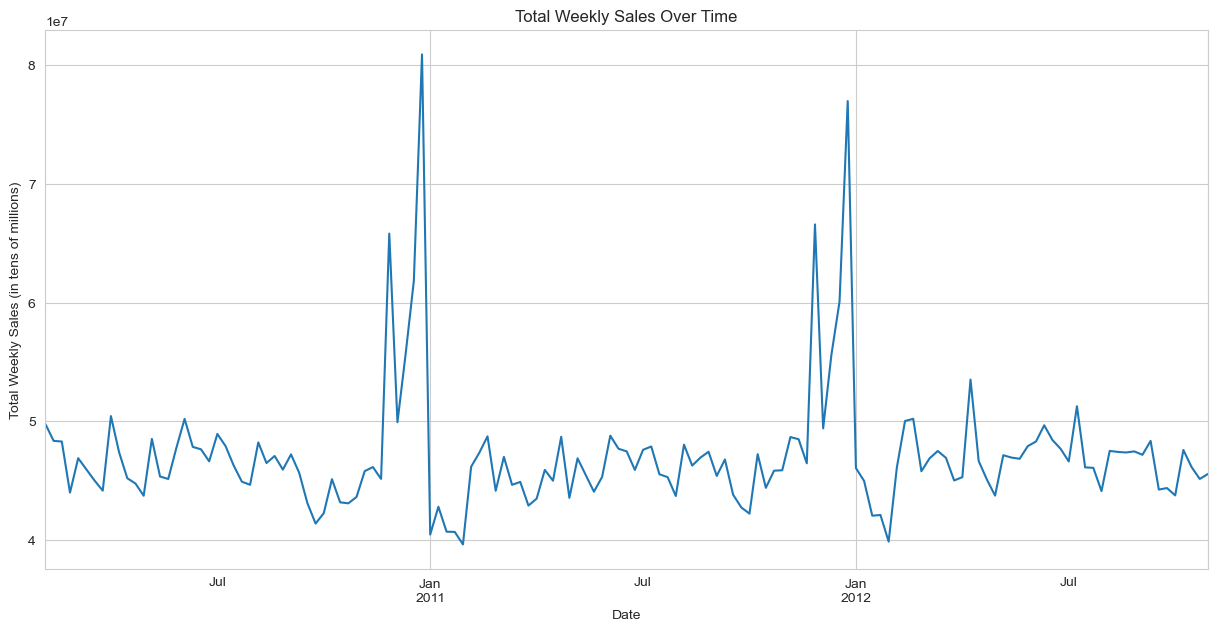

In [9]:
# Set the plot style.
sns.set_style('whitegrid')

# --- Aggregate Sales Data ---
# Resample by week ('W') and sum sales for a high-level view of overall performance.
weekly_sales_agg = df['Weekly_Sales'].resample('W').sum()

# --- Visualize Aggregated Sales ---
print("Plotting total weekly sales...")
plt.figure(figsize=(15, 7))
weekly_sales_agg.plot()
plt.title('Total Weekly Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Total Weekly Sales (in tens of millions)')
plt.show()


Analyzing holiday vs. non-holiday sales distribution


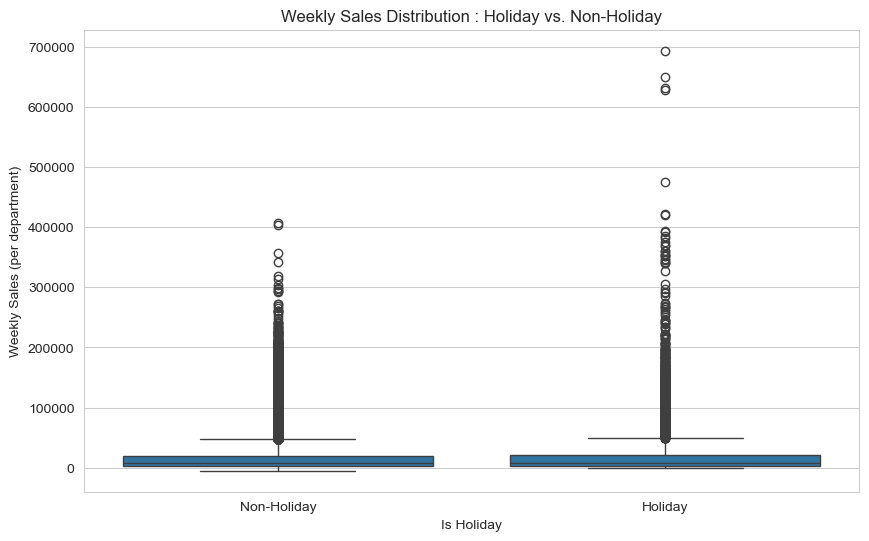

In [10]:
# --- Analyze Holiday Impact ---
# Use a boxplot to compare holiday vs. non-holiday sales distributions.
print("\nAnalyzing holiday vs. non-holiday sales distribution")
plt.figure(figsize=(10, 6))
# Use the original 'df' for a granular view of sales per department.
sns.boxplot(data=df, x='IsHoliday', y='Weekly_Sales')
plt.title("Weekly Sales Distribution : Holiday vs. Non-Holiday")
plt.xlabel('Is Holiday')
plt.ylabel("Weekly Sales (per department)")
plt.xticks([False, True], ['Non-Holiday', 'Holiday'])
plt.show()

### 5. Time Series Decomposition

Decomposing the time series...


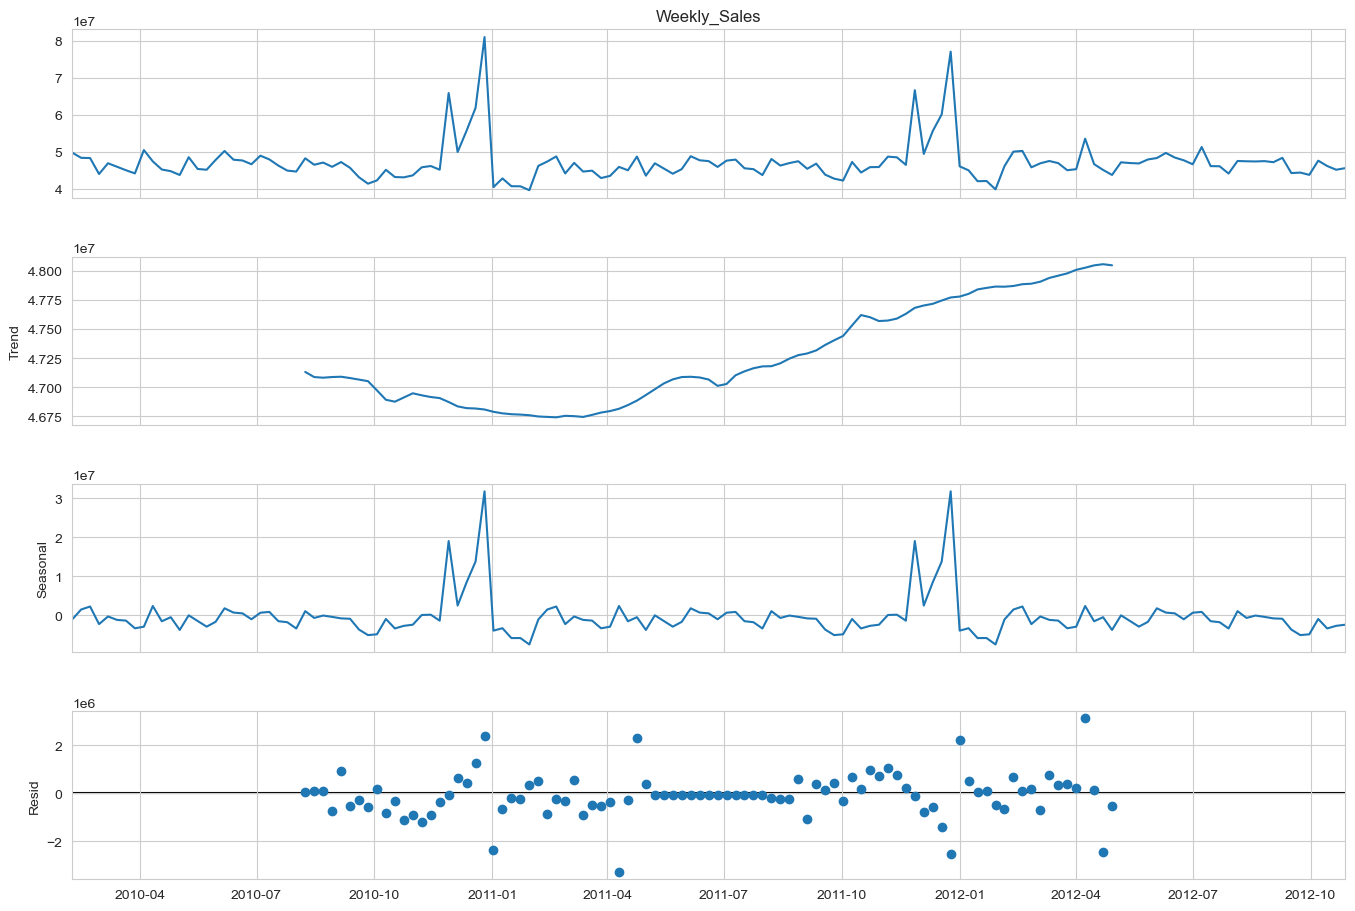

In [12]:
# --- Decompose the Time Series ---
# Decompose the aggregated sales data to formally separate trend, seasonal, and residual components.
# Use a period of 52 for weekly data with yearly seasonality.
decomposition = seasonal_decompose(weekly_sales_agg, model='additive', period=52)

# --- Plot the Decomposed Components ---
print("Decomposing the time series...")
fig = decomposition.plot()
fig.set_size_inches(15, 10)
plt.show()

### 6. Stationarity Testing

In [14]:
# Define a function to perform and interpret the Augmented Dickey-Fuller (ADF) test.
def perform_adf_test(series):
    """
    Perform the Augmented Dickey-Fuller test for stationarity.
    """
    print("--- Augmented Dickey-Fuller Test Results ---")
    
    # Perform the test.
    result = adfuller(series)

    # Print the key test statistics.
    print(f"ADF statistic: {result[0]}")
    print(f"P-Value: {result[1]}")
    print("Critical Values:")
    for key, value in result[4].items():
        print(f"\t{key}: {value}")

    # Print the conclusion based on the p-value.
    if result[1] <= 0.05:
        print("\nConclusion: The data is likely stationary.")
    else:
        print("\nConclusion: The data is likely non-stationary.")

# Test the aggregated weekly sales data.
perform_adf_test(weekly_sales_agg)

--- Augmented Dickey-Fuller Test Results ---
ADF statistic: -5.908297957186331
P-Value: 2.675979158986058e-07
Critical Values:
	1%: -3.47864788917503
	5%: -2.882721765644168
	10%: -2.578065326612056

Conclusion: The data is likely stationary.


#### Apply Seasonal Differencing
A visual inspection and decomposition clearly show seasonality, making the series non-stationary in a practical sense. To prepare the data for a SARIMA model, apply **seasonal differencing** (subtracting the value from 52 weeks prior) to remove the yearly pattern.

Plotting the seasonally differenced sales data...


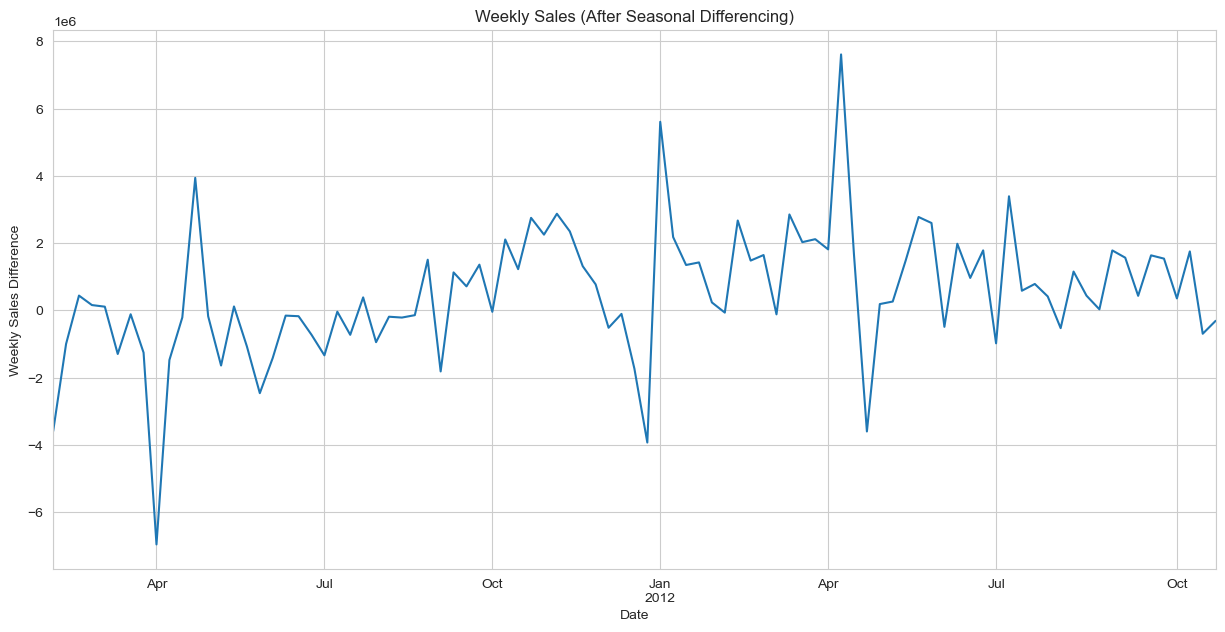

--- Augmented Dickey-Fuller Test Results ---
ADF statistic: -7.3890265507020985
P-Value: 8.092496623964304e-11
Critical Values:
	1%: -3.505190196159122
	5%: -2.894232085048011
	10%: -2.5842101234567902

Conclusion: The data is likely stationary.


In [16]:
# --- Apply Seasonal Differencing ---
# Subtract the value from 52 weeks ago to remove yearly seasonality.
weekly_sales_diff = weekly_sales_agg.diff(periods=52)

# Drop the missing values that result from differencing (the first year's worth).
weekly_sales_diff.dropna(inplace=True)

# --- Visualize the Differenced Data ---
print("Plotting the seasonally differenced sales data...")
plt.figure(figsize=(15, 7))
weekly_sales_diff.plot()
plt.title("Weekly Sales (After Seasonal Differencing)")
plt.xlabel("Date")
plt.ylabel("Weekly Sales Difference")
plt.show()

# --- Test the Differenced Data for Stationarity ---
# Perform the ADF test again on the differenced data to confirm it is now stationary.
perform_adf_test(weekly_sales_diff)

### 7. Modeling - Approach 1: SARIMA

In [18]:
# --- Chronological Train-Test Split ---
# Define the split point for training and testing.
split_date = '2012-01-01'

# Create the training and test sets.
train_data = weekly_sales_agg[weekly_sales_agg.index < split_date]
test_data = weekly_sales_agg[weekly_sales_agg.index >= split_date]

print(f"Training data runs from {train_data.index.min()} to {train_data.index.max()}")
print(f"Test data runs from {test_data.index.min()} to {test_data.index.max()}")

Training data runs from 2010-02-07 00:00:00 to 2011-12-25 00:00:00
Test data runs from 2012-01-01 00:00:00 to 2012-10-28 00:00:00


In [19]:
# --- Fit the SARIMA Model --- 
# Use standard baseline parameters for the model order.
order = (1, 1, 1)
seasonal_order = (1, 1, 1, 52)

# Create and fit the new model on the training data.
model_sarima = SARIMAX(train_data,
                        order=order,
                        seasonal_order=seasonal_order,
                        enforce_stationarity=False,
                        enforce_invertibility=False)

print("\nFitting the SARIMA model... This may take a few minutes.")
results_sarima = model_sarima.fit()

# --- Generate Forecasts and Evaluate ---
# Generate predictions for the same dates as our test data.
forecast = results_sarima.get_forecast(steps=len(test_data))
forecast_mean = forecast.predicted_mean

# Calculate error metrics.
mae_sarima = mean_absolute_error(test_data, forecast_mean)
rmse_sarima = np.sqrt(mean_squared_error(test_data, forecast_mean))

print("\n--- SARIMA Forecast Evaluation ---")
print(f"Mean Absolute Error (MAE): {mae_sarima:,.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse_sarima:,.2f}")


Fitting the SARIMA model... This may take a few minutes.

--- SARIMA Forecast Evaluation ---
Mean Absolute Error (MAE): 3,435,073.50
Root Mean Squared Error (RMSE): 3,790,055.56


### 8. Modeling - Approach 2: Prophet

In [21]:
# --- Prepare Data for Prophet ---
# Prophet requires columns 'ds' (datestamp) and 'y' (value).
# Reset the index to turn 'Date' back into a column.
prophet_df = weekly_sales_agg.reset_index()
prophet_df.rename(columns={'Date': 'ds', 'Weekly_Sales': 'y'}, inplace=True)

# --- Create the Holiday DataFrame ---
# Select only the unique dates that are holidays from the original dataframe 'df'.
holiday_dates = df[df['IsHoliday'] == True].index.unique()

# Create the holidays dataframe in the format Prophet requires.
holidays = pd.DataFrame({
  'holiday': 'Holiday',
  'ds': pd.to_datetime(holiday_dates),
  'lower_window': 0,
  'upper_window': 1, # Allows the holiday effect to spill to the next week
})

# --- Split Data and Train Model ---
# Use the same chronological split.
train_prophet = prophet_df[prophet_df['ds'] < split_date]

# Initialize the Prophet model and include the holidays.
model_prophet = Prophet(holidays=holidays)

# Fit the model to the training data.
print("\nFitting the Prophet model...")
model_prophet.fit(train_prophet)

# --- Generate Future Forecasts ---
future = model_prophet.make_future_dataframe(periods=len(test_data), freq='W')
forecast_prophet = model_prophet.predict(future)

01:33:57 - cmdstanpy - INFO - Chain [1] start processing



Fitting the Prophet model...


01:33:58 - cmdstanpy - INFO - Chain [1] done processing


In [22]:
# --- Evaluate the Prophet Forecast ---
# Align the forecast data with the test set dates.
forecast_test = forecast_prophet[forecast_prophet['ds'].isin(test_data.index)]

# Extract the predicted and actual values.
y_pred_prophet = forecast_test['yhat']
y_true = test_data.values

# Calculate error metrics.
mae_prophet = mean_absolute_error(y_true, y_pred_prophet)
rmse_prophet = np.sqrt(mean_squared_error(y_true, y_pred_prophet))

print("\n--- Prophet Model Evaluation ---")
print(f"Mean Absolute Error (MAE): {mae_prophet:,.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse_prophet:,.2f}")


--- Prophet Model Evaluation ---
Mean Absolute Error (MAE): 3,737,350.98
Root Mean Squared Error (RMSE): 4,206,116.88


### 9. Modeling - Approach 3: Supervised Machine Learning

In [24]:
# --- Feature Engineering for Machine Learning ---
# Create a new dataframe from our aggregated sales series.
ml_df = weekly_sales_agg.to_frame()

# Create time-based, lag, and rolling window features.
ml_df['month'] = ml_df.index.month
ml_df['year'] = ml_df.index.year
ml_df['week_of_year'] = ml_df.index.isocalendar().week
ml_df['sales_lag_1'] = ml_df['Weekly_Sales'].shift(1)
ml_df['sales_lag_52'] = ml_df['Weekly_Sales'].shift(52)
ml_df['rolling_mean_4'] = ml_df['Weekly_Sales'].rolling(window=4).mean()

# Drop rows with missing values created by the feature engineering process.
ml_df.dropna(inplace=True)

# Define our features (X) and target (y).
X = ml_df.drop('Weekly_Sales', axis=1)
y = ml_df['Weekly_Sales']

# Display the first few rows of the new feature set.
print("--- Engineered Features for ML Model (X) ---")
print(X.head())

--- Engineered Features for ML Model (X) ---
            month  year  week_of_year  sales_lag_1  sales_lag_52  \
Date                                                               
2011-02-06      2  2011             5  39599852.99   49750740.50   
2011-02-13      2  2011             6  46153111.12   48336677.63   
2011-02-20      2  2011             7  47336192.79   48276993.78   
2011-02-27      2  2011             8  48716164.12   43968571.13   
2011-03-06      3  2011             9  44125859.84   46871470.30   

            rolling_mean_4  
Date                        
2011-02-06    4.177032e+07  
2011-02-13    4.343595e+07  
2011-02-20    4.545133e+07  
2011-02-27    4.658283e+07  
2011-03-06    4.678971e+07  


In [25]:
# --- Chronological Train-Test Split for ML Model ---
# Create the training and test sets from the engineered feature dataframe.
X_train_ml = X[X.index < split_date]
y_train_ml = y[y.index < split_date]
X_test_ml = X[X.index >= split_date]
y_test_ml = y[y.index >= split_date]

print(f"ML model training set size: {len(X_train_ml)}")
print(f"ML model test set size: {len(X_test_ml)}")

ML model training set size: 47
ML model test set size: 44


In [26]:
# --- Initialize, Train, and Evaluate the XGBoost Model ---
# Use early stopping to find the optimal number of trees and prevent overfitting.
model_xgb = xgb.XGBRegressor(
    n_estimators=1000,
    learning_rate=0.01,
    early_stopping_rounds=50,
    objective='reg:squarederror',
    n_jobs=-1
)

print("\nTraining the XGBoost model...")
# Fit the model on the training data, using test data for early stopping evaluation.
model_xgb.fit(X_train_ml, y_train_ml,
              eval_set=[(X_test_ml, y_test_ml)],
              verbose=False)

# Make predictions on the test set.
y_pred_xgb = model_xgb.predict(X_test_ml)

# Calculate error metrics.
mae_xgb = mean_absolute_error(y_test_ml, y_pred_xgb)
rmse_xgb = np.sqrt(mean_squared_error(y_test_ml, y_pred_xgb))


Training the XGBoost model...


In [27]:
# --- Final Model Comparison --- 
print("--- Final Model Comparison (MAE) ---")
print(f"SARIMA:  ${mae_sarima:,.2f}")
print(f"Prophet: ${mae_prophet:,.2f}")
print(f"XGBoost: ${mae_xgb:,.2f}")

--- Final Model Comparison (MAE) ---
SARIMA:  $3,435,073.50
Prophet: $3,737,350.98
XGBoost: $1,408,512.62


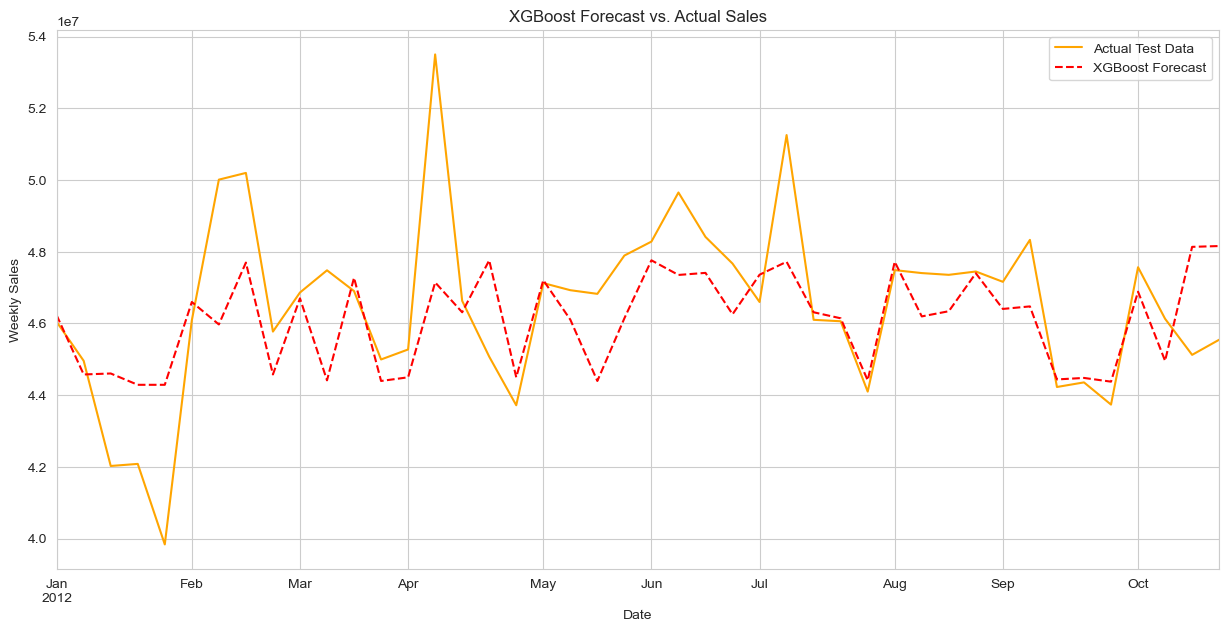

In [28]:
# --- Visualize the XGBoost Forecast ---
results_df = y_test_ml.to_frame()
results_df['XGBoost_Forecast'] = y_pred_xgb

plt.figure(figsize=(15, 7))

# Plot actual test data.
y_test_ml.plot(label='Actual Test Data', color='orange')
# Plot forecasted data.
results_df['XGBoost_Forecast'].plot(label='XGBoost Forecast', color='red', linestyle='--')

plt.title("XGBoost Forecast vs. Actual Sales")
plt.xlabel("Date")
plt.ylabel("Weekly Sales")
plt.legend()
plt.show()

### 10. Project Conclusion
This project successfully developed and compared three different forecasting methodologies—classical statistical (SARIMA), modern automated (Prophet), and supervised machine learning (XGBoost)—to predict weekly retail sales.

#### Final Performance Results

Here is a summary of the performance for each model, with the Mean Absolute Error (MAE) as the key metric for comparison.

**SARIMA Model (Benchmark)**
* **Methodology:** Statistical
* **Mean Absolute Error (MAE):** $3,435,074

**Prophet Model**
* **Methodology:** Automated Library
* **Mean Absolute Error (MAE):** $3,737,351

**XGBoost Model (Winner)**
* **Methodology:** Machine Learning
* **Mean Absolute Error (MAE):** **$1,408,513**

--- 

#### Verdict

The **supervised machine learning approach using XGBoost and engineered features was the most effective strategy**, delivering a forecast that was more than twice as accurate as the other models.

This demonstrates the power of converting a time series problem into a feature-rich regression problem. 
While SARIMA provided a solid statistical benchmark, the ability of XGBoost to learn complex, non-linear relationships from features like sales lags and rolling averages allowed it to capture the underlying dynamics of the sales data with far greater precision. 
This model would provide the most business value for applications such as inventory planning and revenue forecasting.